In [28]:
import pickle
import itertools
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import sacrebleu
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=0.73)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
wmt_scored = pickle.load(open('wmt16-19_toen_scored.pkl', 'rb'))
wmt_scored.head(1)

,lp,HITId,WorkerId,score,time,system,type,sid,reference,source,...,chrf:statistics_10,chrf:statistics_11,chrf:statistics_12,chrf:statistics_13,chrf:statistics_14,chrf:statistics_15,chrf:statistics_16,chrf:statistics_17,bert_score:f1,bleurt_score
0,de-en,3QQUBC64ZEEFIPT2SKINDZZTZ3SNXN,A0077,78,2052.0,online-G,SYSTEM,1906,Rather than having an executive make the annou...,Anstatt einen Manager die Ankündigung machen z...,...,151,95,145,150,85,144,149,76,0.941347,-0.00404


In [3]:
wmt_scored.type.value_counts()

SYSTEM    585386
REPEAT     75998
Name: type, dtype: int64

In [4]:
true_means = wmt_scored.groupby(['year','lp', 'system'])[['score']].mean()
true_means

score
year lp    system                   
2016 cs-en PJATK           69.001067
           cu-mergedtrees  56.020474
           jhu-pbmt        72.411999
           online-A        69.633523
           online-B        70.983888
...                              ...
2019 zh-en online-A.0      75.306259
           online-B.0      80.686373
           online-G.0      72.351598
           online-X.0      66.889482
           online-Y.0      78.002909

[261 rows x 1 columns]

In [5]:
def pairs(x):
    for (year, lp), group in x.groupby(['year', 'lp']):
        systems = group.system.unique()
        
        for i, j in itertools.combinations(systems, 2):
            yield (year, lp), i, j
            
all_pairs = list(pairs(wmt_scored))
pairs_2019 = list(pairs(wmt_scored[wmt_scored.year == 2019]))
print(len(all_pairs))
print(all_pairs[-1])

def get_preds(all_pairs, scores, only_2019=False):
    if only_2019:
        all_pairs = pairs_2019
    
    preds = np.zeros(len(all_pairs))
    if type(scores) == type({}):
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores[year, lp, i] - scores[year, lp, j] > 0 else 0
    else:
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores.loc[year, lp, i] - scores.loc[year, lp, j] > 0 else 0
            
    return preds

true_preds = get_preds(all_pairs, true_means['score'])

1324
((2019, 'zh-en'), 'online-X.0', 'MSRA.MASS.6942')


In [6]:
# BLEU
def bleu_agg(x):
    cols = [ ('bleu:counts_%d' % i) for i in range(0, 4) ] + [ ('bleu:totals_%d' % i) for i in range(0, 4) ]
    cols += ['bleu:sys_len', 'bleu:ref_len']
    aggs = x[cols].sum()

    totals = [ aggs['bleu:totals_%d' % i] for i in range(0, 4) ]
    counts = [ aggs['bleu:counts_%d' % i] for i in range(0, 4) ]
    ref_len = aggs['bleu:ref_len']
    sys_len = aggs['bleu:sys_len']

    return sacrebleu.compute_bleu(counts, totals, sys_len, ref_len).score

# TER
def ter_agg(x):
    cols = [ 'ter:num_edits', 'ter:ref_length' ]
    aggs = x[cols].sum()

    num_edits = aggs['ter:num_edits']
    ref_length = aggs['ter:ref_length']

    # for one reference
    return -num_edits / ref_length


# chrf
def chrf_agg(x):
    cols = [ ('chrf:statistics_%d' % i) for i in range(0, 18) ]
    aggs = x[cols].sum()

    statistics = [ aggs['chrf:statistics_%d' % i] for i in range(0, 18) ]

    return sacrebleu.CHRF.compute_chrf(statistics, order=6, beta=2).score

def bert_score_agg(x):
    return x['bert_score:f1'].mean()

def bleurt_agg(x):
    return x['bleurt_score'].mean()

def human_agg(x):
    return x['score'].mean()

In [7]:
# taken from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_decomposition(metric_results, true_preds):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    avg_expected_loss = (true_preds != metric_results).mean()

    avg_bias = (main_predictions != true_preds).mean()

    signs = (main_predictions == true_preds).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias, avg_var_contrib

# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_noise_decomposition(metric_results, human_results, true_preds, no_bias=False):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    optimal_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=human_results)
    
    if no_bias:
        main_predictions = optimal_predictions
    true_preds = optimal_predictions
    
    avg_expected_loss = (human_results != metric_results).mean()

    noises = (human_results != true_preds).mean(axis=0)
    probs = (metric_results == true_preds).mean(axis=0)

    avg_noise_contrib = ((2 * probs - 1) * noises).mean()

    avg_bias = (main_predictions != true_preds).mean()

    signs = (main_predictions == true_preds).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib

In [8]:
pooled_vars = json.load(open('vars/pooled_vars_toen.json', 'rt'))
total_vars = json.load(open('vars/total_vars_toen.json', 'rt'))

ratios = {}
ratios[2016] = total_vars['wmt16'] / (total_vars['wmt16'] - pooled_vars['wmt16'])
ratios[2017] = total_vars['wmt17'] / (total_vars['wmt17'] - pooled_vars['wmt17'])
ratios[2018] = total_vars['wmt18'] / (total_vars['wmt18'] - pooled_vars['wmt18'])
ratios[2019] = total_vars['wmt19'] / (total_vars['wmt19'] - pooled_vars['wmt19'])

ratios

{2016: 1.5178558843542491,
 2017: 2.4985504207084577,
 2018: 1.9267408629310268,
 2019: 2.2356780848518056}

In [10]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(metric):
    groups = [ g.sample(frac=1, replace=True) for i, g in cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    
    d = { label:mean for label, mean in zip(labels, observed_means) }
    return get_preds(all_pairs, d)

with Pool(12) as p:
    it = tqdm(p.imap_unordered(f, [None]*10000, chunksize=10), total=10000)
    output = list(it)
    human_results = np.array(output, dtype=np.int64)
    
# optimal predictions
optimal_predictions = np.apply_along_axis(lambda x:
                                   np.argmax(np.bincount(x)),
                                   axis=0,
                                   arr=human_results)

optimal_predictions

array([0, 1, 1, ..., 1, 0, 0])

In [11]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(x):
    n, ratios = x
    
    groups = [ g.sample(frac=1, replace=True) for i, g in cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    observed_means = { label:mean for label, mean in zip(labels, observed_means) }
    
    # humans
    groups = [ g.sample(n=n, replace=True) for i, g in cached ]
    human_means = [ g['score'].mean() for g in groups ]
    human_means = { label:mean for label, mean in zip(labels, human_means) }

    # theoretical
    groups = [ g.sample(n=int(n*ratios[i[0]]), replace=True) for i, g in cached ]
    pa_means = [ g['score'].mean() for g in groups ]
    pa_means = { label:mean for label, mean in zip(labels, pa_means) }

    return get_preds(all_pairs, observed_means), get_preds(all_pairs, human_means), get_preds(all_pairs, pa_means)

WORKERS = 12
NUM_TRIALS = 10000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
metrics = [100, 200, 300, 400, 500, 600, 700]
results = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        it = tqdm(p.imap_unordered(f, [(metric, ratios)]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)

        label_results = np.array([ i[0] for i in output ], dtype=np.int64)
        human_results = np.array([ i[1] for i in output ], dtype=np.int64)
        pa_results = np.array([ i[2] for i in output ], dtype=np.int64)
        
        results[metric] = (bias_var_noise_decomposition(human_results, label_results, true_preds, no_bias=True),
                          bias_var_noise_decomposition(pa_results, label_results, true_preds, no_bias=True))

In [12]:
for metric, (human, pa) in sorted(list(results.items()), key=lambda x: x[1][0]):
    avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib = human
    print(metric)
    print(avg_expected_loss)
    print(avg_noise_contrib + avg_bias + avg_var_contrib)

700
0.09117009063444109
0.09137686687311179
600
0.09591691842900302
0.09605719220543807
500
0.10145626888217522
0.10149338812688821
400
0.10962190332326284
0.1095287510574018
300
0.12056223564954682
0.12075822228096678
200
0.1378297583081571
0.13766070693353477
100
0.1739750755287009
0.17385151234138974


In [13]:
bvd_results = json.load(open('bvd_results_wmt.json', 'rt'))
print(bvd_results)

{'bleurt': [0.1280742388758782, 0.11241217798594848, 0.004133723653395783, 0.011459342622950818], 'human': [0.06536132930513595, 0.0, 0.04656593655589123, 0.018479260075528702], 'true_preds': [0.04681170694864048, 0.0, 0.0022658610271903325, 0.044545845921450146], 'bleu': [0.14136503021148036, 0.1268882175226586, 0.008235649546827794, 0.006162033927492447], 'ter': [0.18422069486404835, 0.1729607250755287, 0.00224690332326284, 0.008913126087613292], 'chrf': [0.12428489425981873, 0.10649546827794562, 0.009616238670694863, 0.008104985951661632], 'bert_score': [0.10233723564954683, 0.08610271903323263, 0.003863519637462236, 0.012472721253776436]}


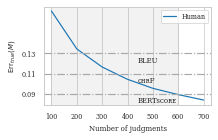

In [38]:
x = list(range(100, 701, 100))
y = [results[i][0][2] for i in x]
y_pa = [results[i][1][2] for i in x]

plt.figure(figsize=(3, 1.8))
ax = sns.lineplot(x=x, y=y, label='Human')
#sns.lineplot(x=x, y=y_pa, label='Perfect annotator')
ax.set(xlabel='Number of judgments', ylabel='$\\mathrm{Err}_{true}(M)$')
ax.yaxis.grid(False)
#ax.legend(loc='upper right')

names = {
    'bleu' : 'BLEU',
    'chrf' : 'ᴄʜʀF',
    'bert_score' : 'BERTsᴄᴏʀᴇ'
}

biases = []
for metric, (err, bias, noise, var) in bvd_results.items():
    if metric in ['true_preds', 'human', 'ter', 'bleurt']:
        continue
    ax.axhline(bias, color='darkgrey', linestyle='-.')
    
    metric = names[metric]
    
    ax.annotate(metric, (440, bias-0.009), font={'variant':'small-caps'})
    biases.append(bias)
plt.yticks(biases, ['%.2f' % i for i in biases])
    
plt.axvspan(100, 600, color='grey', alpha=0.1)
plt.savefig('human_comparison_wmt.pdf', bbox_inches='tight')